In [1]:
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow.compat.v1 as tf1
tf1.disable_v2_behavior() 
import tensorflow as tf2
from sklearn.preprocessing import MinMaxScaler

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
df = pd.read_csv('qqq_data.txt',delimiter = ',',usecols = ['Date','Open','High','Low','Close','Volume'])
print("Data loading from repository")

Data loading from repository


In [3]:
df.head()

,Date,Open,High,Low,Close,Volume
0,1999-03-10,45.722,45.750,44.967,45.665,11700414
1,1999-03-11,45.994,46.260,44.988,45.880,21670048
2,1999-03-12,45.721,45.749,44.406,44.770,19553768
3,1999-03-15,45.101,46.103,44.625,46.052,14245348
4,1999-03-16,46.253,46.643,45.749,46.447,10971066


In [4]:
df.loc[10]

Date      1999-03-24
Open          44.045
High          45.164
Low           43.374
Close         45.136
Volume      18890150
Name: 10, dtype: object

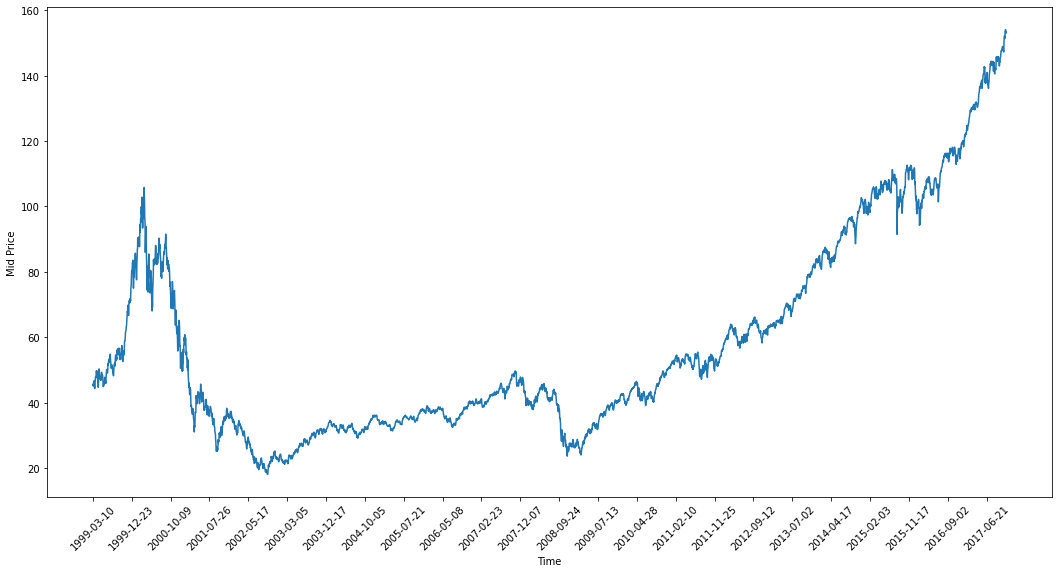

In [5]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],200),df['Date'].loc[::200],rotation = 45)
plt.xlabel('Time')
plt.ylabel('Mid Price')
plt.show()

In [6]:
# The first colon denotes using all the rows and the 'High' label is for the column and then we make a numpy array out of that
high_prices = df.loc[:,'High'].to_numpy()
low_prices = df.loc[:,'Low'].to_numpy()
mid_prices = (high_prices+low_prices)/2.0

In [7]:
train_data = mid_prices[:4000]
test_data = mid_prices[4000:]

In [8]:
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)
print(train_data.shape)
print(test_data.shape)

(4000, 1)
(701, 1)


In [9]:
#Normalizing over 4 different time periods because stock prices vary greatly and we want equal importance
smoothing_window_size = 1000
for di in range(0,4000,smoothing_window_size):
        scaler.fit(train_data[di:di+smoothing_window_size,:])
        train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

In [10]:
train_data = train_data.reshape(-1)

In [11]:
test_data.shape

(701, 1)

In [12]:
#Normalizing test data
test_data = scaler.transform(test_data)

In [13]:
test_data

array([[0.94325169],
       [0.95338789],
       [0.96066146],
       [0.96264189],
       [0.95318984],
       [0.96993348],
       [0.98379648],
       [1.00135029],
       [1.0161135 ],
       [1.02223482],
       [1.02439529],
       [1.03168688],
       [1.03987865],
       [1.04780037],
       [1.04888061],
       [1.0502309 ],
       [1.05140115],
       [1.05194127],
       [1.05977297],
       [1.05374166],
       [1.04663012],
       [1.05203129],
       [1.04086887],
       [1.03483756],
       [1.01314285],
       [0.99900979],
       [0.99729941],
       [0.99657926],
       [1.01026223],
       [1.01755381],
       [1.02835615],
       [1.04410957],
       [1.06040311],
       [1.05563207],
       [1.05266143],
       [1.02547553],
       [0.99315852],
       [0.99981996],
       [1.01998434],
       [1.01323287],
       [0.99360861],
       [0.9958591 ],
       [0.99918982],
       [1.01575342],
       [1.01674363],
       [1.02520547],
       [1.03573776],
       [1.044

In [14]:
test_data = test_data.reshape(-1)

In [15]:
# Doing exponential moving average on the data to smooth it out and discard the raggedness
# Only done on training data
EMA = 0.0
gamma = 0.1
for ti in range(4000):
    EMA = gamma*train_data[ti] + (1-gamma)*EMA
    train_data[ti] = EMA
# For visualization
all_mid_data = np.concatenate([train_data,test_data],axis = 0)

In [16]:
all_mid_data.shape

(4701,)

In [17]:
all_mid_data

array([0.03112394, 0.05943803, 0.08429795, ..., 1.92567087, 1.90514642,
       1.91396833])

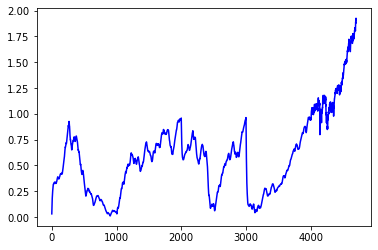

In [18]:
plt.plot(range(df.shape[0]),all_mid_data, color = 'b')
plt.show()

In [19]:
# Trying the standard averaging technique first and checking its results for a certian window size
window_size = 40
N = train_data.size
std_avg_predictions = []
mse_errors = []

for pred_index in range(window_size,N):
    std_avg_predictions.append(np.mean(train_data[pred_index-window_size:pred_index]))
    mse_errors.append((std_avg_predictions[-1] - train_data[pred_index])**2)
print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00236


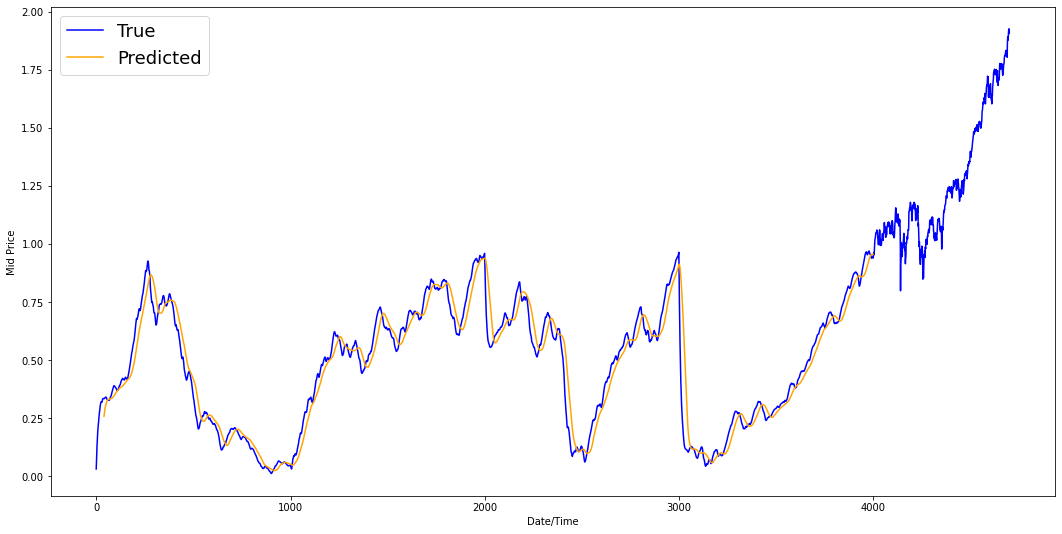

In [20]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data, color = 'b', label = 'True')
plt.plot(range(window_size,N),std_avg_predictions, color = 'orange', label = 'Predicted')
plt.xlabel('Date/Time')
plt.ylabel('Mid Price')
plt.legend(fontsize = 18)
plt.show()

In [21]:
# Trying the exponential moving average method for predicting the recent stock price
window_size = 40
N = train_data.size
run_avg_predictions = []
mse_errors = []
running_mean = 0.0
run_avg_predictions.append(running_mean)
decay = 0.5
for pred_index in range(1,N):
    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_index-1];
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_index])**2)
print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00005


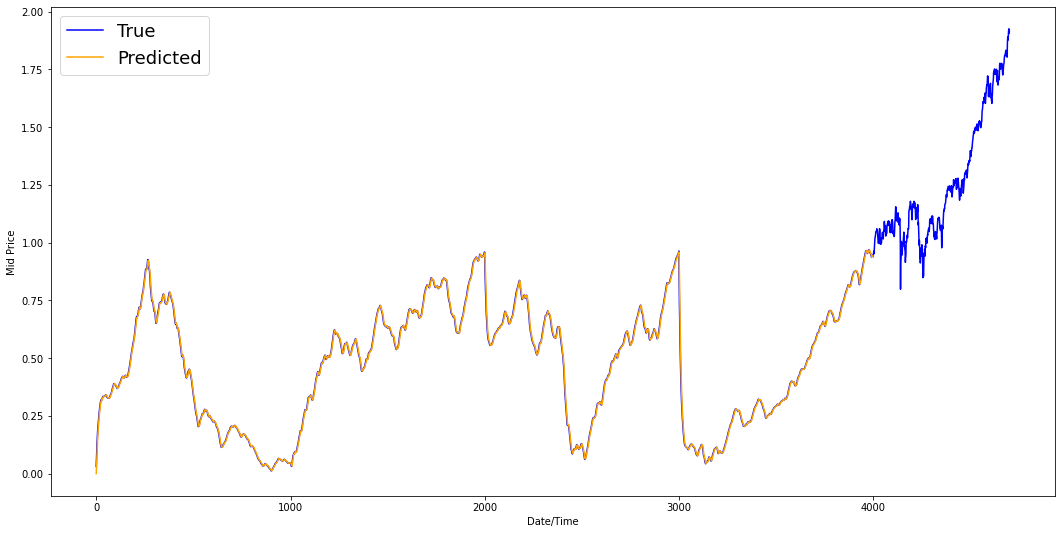

In [22]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color = 'b', label = 'True')
plt.plot(range(0,N),run_avg_predictions,color='orange',label = 'Predicted')
plt.xlabel('Date/Time')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [23]:
# EMA works very well for one day prediction but not very useful practically

In [24]:
df.shape

(4701, 6)

In [ ]:
# Data Generation and Data augmentation part used for training the model
class DataGeneratorSeq(object):
    
    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]
    
    def next_batch(self):
        batch_data = np.zeros((self._batch_size),dtype = np.float32)
        batch_labels = np.zeros((self._batch_size),dtype = np.float32)
        as
        for b in range(self._batch_size):
            if self._cursor[b] + 1 >= self._prices_length:
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)
            
            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b] = self._prices[self._cursor[b] + np.random.randint(0,5)]
            
            self._cursor[b] = (self._cursor[b] + 1) % self._prices_length
            
        return batch_data,batch_labels
    
    def unroll_batches(self):
        
        unroll_data,unroll_labels = [],[]
        init_data, init_label = None, None
        for ui in range(self._num_unroll):
            
            data,labels = self.next_batch()
            
            unroll_data.append(data)
            unroll_labels.append(labels)
            
        return unroll_data, unroll_labels
    
    def reset_indices(self):
        for b in range(self._batch_size):
                self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))
                
    
dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat)
    print('\n\tOutput: ',lbl)

In [ ]:
# Defining the hyperparameters
D = 1
num_unrollings = 5
batch_size = 200
num_nodes = [200,200,150]
n_layers = len(num_nodes)
dropout = 0.2

tf1.reset_default_graph()
# This is important in case you run this multiple times

In [ ]:
pip show tensorflow

In [ ]:
#Input data
train_inputs, train_outputs = [],[]
tf1.disable_eager_execution() # It was not compatible with eager execution
# Your unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf1.placeholder(tf1.float32,shape=[batch_size,D],name = 'train_inputs_%d'%ui))
    train_outputs.append(tf1.placeholder(tf1.float32,shape=[batch_size,1], name = 'train_outputs_%d'%ui))
# Some functions are deprecated in tf v2 so have to go back to tf v1

In [ ]:
lstm_cells = [
    tf2.compat.v1.nn.rnn_cell.LSTMCell(num_units=num_nodes[li],
                           state_is_tuple = True,
                           initializer = tf2.initializers.GlorotUniform()
                           )
    for li in range(n_layers)]

drop_lstm_cells = [tf2.compat.v1.nn.rnn_cell.DropoutWrapper(
        lstm, input_keep_prob = 1.0, output_keep_prob = 1.0 - dropout, state_keep_prob = 1.0 - dropout)
        for lstm in lstm_cells]
drop_multi_cell = tf2.compat.v1.keras.layers.StackedRNNCells(drop_lstm_cells)
multi_cell = tf2.compat.v1.keras.layers.StackedRNNCells(lstm_cells)

w = tf2.compat.v1.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf2.initializers.GlorotUniform())
b = tf2.compat.v1.get_variable('b',initializer=tf2.random.uniform([1],-0.1,0.1))

In [ ]:
c,h = [],[]
initial_state = []
for li in range(n_layers):
    c.append(tf2.Variable(tf1.zeros([batch_size,num_nodes[li]]), trainable = False))
    h.append(tf2.Variable(tf1.zeros([batch_size,num_nodes[li]]), trainable = False))
    initial_state.append(tf2.compat.v1.nn.rnn_cell.LSTMStateTuple(c[li],h[li]))
all_inputs = tf1.concat([tf2.expand_dims(t,0) for t in train_inputs],axis = 0)

all_lstm_outputs, state = tf1.nn.dynamic_rnn(
    drop_multi_cell, all_inputs, initial_state = tuple(initial_state),
    time_major = True, dtype = tf1.float32)

all_lstm_outputs = tf1.reshape(all_lstm_outputs, [batch_size*num_unrollings, num_nodes[-1]])

all_outputs = tf1.nn.xw_plus_b(all_lstm_outputs,w,b)

split_outputs = tf1.split(all_outputs,num_unrollings,axis=0)

In [ ]:
print("Defining training loss")
loss = 0.0
with tf2.control_dependencies([tf1.assign(c[li],state[li][0]) for li in range(n_layers)]+
                             [tf1.assign(h[li],state[li][1]) for li in range(n_layers)]):
    for ui in range(num_unrollings):
        loss += tf2.reduce_mean(0.5*(split_outputs[ui] - train_outputs[ui])**2)
        
print("Learning decay rate operations")
global_step = tf2.Variable(0, trainable = False)
inc_gstep = tf1.assign(global_step,global_step + 1)
tf_learning_rate = tf1.placeholder(shape = None, dtype = tf1.float32)
tf_min_learning_rate = tf1.placeholder(shape = None, dtype = tf1.float32)

learning_rate = tf2.maximum(
    tf1.train.exponential_decay(tf_learning_rate, global_step, decay_steps = 1, decay_rate = 0.5, staircase = True),
    tf_min_learning_rate)

#Optimizer
print("TF Optimization operations")
optimizer = tf1.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf1.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(
    zip(gradients,v))

print('\tAll Done')

In [ ]:
print('Defining prediction related TF functions')

sample_inputs = tf1.placeholder(tf1.float32, shape = [1,D])

#Maintaining LSTM state for prediction stage
sample_c, sample_h, initial_sample_state = [],[],[]
for li in range(n_layers):
    sample_c.append(tf1.Variable(tf1.zeros([1,num_nodes[li]]), trainable = False))
    sample_h.append(tf1.Variable(tf1.zeros([1,num_nodes[li]]), trainable = False))
    initial_sample_state.append(tf2.compat.v1.nn.rnn_cell.LSTMStateTuple(sample_c[li],sample_h[li]))
    
reset_sample_states = tf1.group(*[tf1.assign(sample_c[li],tf1.zeros([1,num_nodes[li]])) for li in range(n_layers)],
                               *[tf1.assign(sample_h[li],tf1.zeros([1,num_nodes[li]])) for li in range(n_layers)])

sample_outputs, sample_state = tf1.nn.dynamic_rnn(multi_cell, tf1.expand_dims(sample_inputs,0),
                                initial_state = tuple(initial_sample_state),
                                time_major = True,
                                dtype = tf1.float32)

with tf1.control_dependencies([tf1.assign(sample_c[li],sample_state[li][0]) for li in range(n_layers)]+
                             [tf1.assign(sample_h[li], sample_state[li][1]) for li in range(n_layers)]):
    sample_prediction = tf1.nn.xw_plus_b(tf1.reshape(sample_outputs,[1,-1]), w, b)
    
print('\tAll done')
        

In [ ]:
epochs = 30
valid_summary = 1 # Interval you make test predictions

n_predict_once = 5 # Number of steps you continously predict for

train_seq_length = train_data.size # Full length of the training data

train_mse_ot = [] # Accumulate Train losses
test_mse_ot = [] # Accumulate Test loss
predictions_over_time = [] # Accumulate predictions

session = tf1.InteractiveSession()

tf1.global_variables_initializer().run()

# Used for decaying learning rate
loss_nondecrease_count = 0
loss_nondecrease_threshold = 2 # If the test error hasn't increased in this many steps, decrease learning rate

print('Initialized')
average_loss = 0

# Define data generator
data_gen = DataGeneratorSeq(train_data,batch_size,num_unrollings)

x_axis_seq = []

# Points you start your test predictions from
test_points_seq = np.arange(4000,4700,5).tolist()

for ep in range(epochs):       

    # ========================= Training =====================================
    for step in range(train_seq_length//batch_size):

        u_data, u_labels = data_gen.unroll_batches()

        feed_dict = {}
        for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
            feed_dict[train_inputs[ui]] = dat.reshape(-1,1)
            feed_dict[train_outputs[ui]] = lbl.reshape(-1,1)

        feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate:0.000001})

        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        average_loss += l

    # ============================ Validation ==============================
    if (ep+1) % valid_summary == 0:

      average_loss = average_loss/(valid_summary*(train_seq_length//batch_size))

      # The average loss
      if (ep+1)%valid_summary==0:
        print('Average loss at step %d: %f' % (ep+1, average_loss))

      train_mse_ot.append(average_loss)

      average_loss = 0 # reset loss

      predictions_seq = []

      mse_test_loss_seq = []

      # ===================== Updating State and Making Predicitons ========================
      for w_i in test_points_seq:
        mse_test_loss = 0.0
        our_predictions = []

        if (ep+1)-valid_summary==0:
          # Only calculate x_axis values in the first validation epoch
          x_axis=[]

        # Feed in the recent past behavior of stock prices
        # to make predictions from that point onwards
        for tr_i in range(w_i-num_unrollings+1,w_i-1):
          current_price = all_mid_data[tr_i]
          feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)    
          _ = session.run(sample_prediction,feed_dict=feed_dict)

        feed_dict = {}

        current_price = all_mid_data[w_i-1]

        feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)

        # Make predictions for this many steps
        # Each prediction uses previous prediciton as it's current input
        for pred_i in range(n_predict_once):

          pred = session.run(sample_prediction,feed_dict=feed_dict)

          our_predictions.append(np.asscalar(pred))

          feed_dict[sample_inputs] = np.asarray(pred).reshape(-1,1)

          if (ep+1)-valid_summary==0:
            # Only calculate x_axis values in the first validation epoch
            x_axis.append(w_i+pred_i)

          mse_test_loss += 0.5*(pred-all_mid_data[w_i+pred_i])**2

        session.run(reset_sample_states)

        predictions_seq.append(np.array(our_predictions))

        mse_test_loss /= n_predict_once
        mse_test_loss_seq.append(mse_test_loss)

        if (ep+1)-valid_summary==0:
          x_axis_seq.append(x_axis)

      current_test_mse = np.mean(mse_test_loss_seq)

      # Learning rate decay logic
      if len(test_mse_ot)>0 and current_test_mse > min(test_mse_ot):
          loss_nondecrease_count += 1
      else:
          loss_nondecrease_count = 0

      if loss_nondecrease_count > loss_nondecrease_threshold :
            session.run(inc_gstep)
            loss_nondecrease_count = 0
            print('\tDecreasing learning rate by 0.5')

      test_mse_ot.append(current_test_mse)
      print('\tTest MSE: %.5f'%np.mean(mse_test_loss_seq))
      predictions_over_time.append(predictions_seq)
      print('\tFinished Predictions')

In [ ]:
best_prediction_epoch = 28 # replace this with the epoch that you got the best results when running the plotting code

plt.figure(figsize = (18,18))
plt.subplot(2,1,1)
plt.plot(range(df.shape[0]),all_mid_data,color='b')

# Plotting how the predictions change over time
# Plot older predictions with low alpha and newer predictions with high alpha
start_alpha = 0.25
alpha  = np.arange(start_alpha,1.1,(1.0-start_alpha)/len(predictions_over_time[::3]))
for p_i,p in enumerate(predictions_over_time[::3]):
    for xval,yval in zip(x_axis_seq,p):
        plt.plot(xval,yval,color='r',alpha=alpha[p_i])

plt.title('Evolution of Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(4000,4701)

plt.subplot(2,1,2)

# Predicting the best test prediction you got
plt.plot(range(df.shape[0]),all_mid_data,color='b')
for xval,yval in zip(x_axis_seq,predictions_over_time[best_prediction_epoch]):
    plt.plot(xval,yval,color='r')

plt.title('Best Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(4000,4701)
plt.show()